In [1]:
import pandas as pd

movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

# Merge on 'title'
movies = movies.merge(credits, on='title')


In [2]:
# Keep only useful columns
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.head()


,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [3]:
import ast

# Helper function to extract names from JSON string
def extract_names(text):
    try:
        return [i['name'] for i in ast.literal_eval(text)]
    except:
        return []

# For crew: only director
def extract_director(text):
    try:
        return [i['name'] for i in ast.literal_eval(text) if i['job'] == 'Director']
    except:
        return []

movies['genres'] = movies['genres'].apply(extract_names)
movies['keywords'] = movies['keywords'].apply(extract_names)
movies['cast'] = movies['cast'].apply(lambda x: extract_names(x)[:3])  # Top 3 cast
movies['crew'] = movies['crew'].apply(extract_director)


In [4]:
# Combine into a single string per movie
movies['overview'] = movies['overview'].fillna('')
movies['tags'] = movies['overview'] + " " + movies['genres'].apply(lambda x: " ".join(x)) + " " + \
                 movies['keywords'].apply(lambda x: " ".join(x)) + " " + \
                 movies['cast'].apply(lambda x: " ".join(x)) + " " + \
                 movies['crew'].apply(lambda x: " ".join(x))

final = movies[['movie_id', 'title', 'tags']]
final['tags'] = final['tags'].str.lower()


C:\Users\yuvan\AppData\Local\Temp\ipykernel_27488\3528071228.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['tags'] = final['tags'].str.lower()


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize text
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
vectors = tfidf.fit_transform(final['tags']).toarray()

# Compute similarity
similarity = cosine_similarity(vectors)


In [6]:
def recommend(movie_title):
    idx = final[final['title'] == movie_title].index[0]
    distances = list(enumerate(similarity[idx]))
    sorted_movies = sorted(distances, key=lambda x: x[1], reverse=True)[1:6]

    print(f"Top 5 movies similar to '{movie_title}':")
    for i in sorted_movies:
        print(final.iloc[i[0]].title)


In [7]:
recommend("The Dark Knight")


Top 5 movies similar to 'The Dark Knight':
The Dark Knight Rises
Batman Begins
Batman Returns
Batman Forever
Batman v Superman: Dawn of Justice


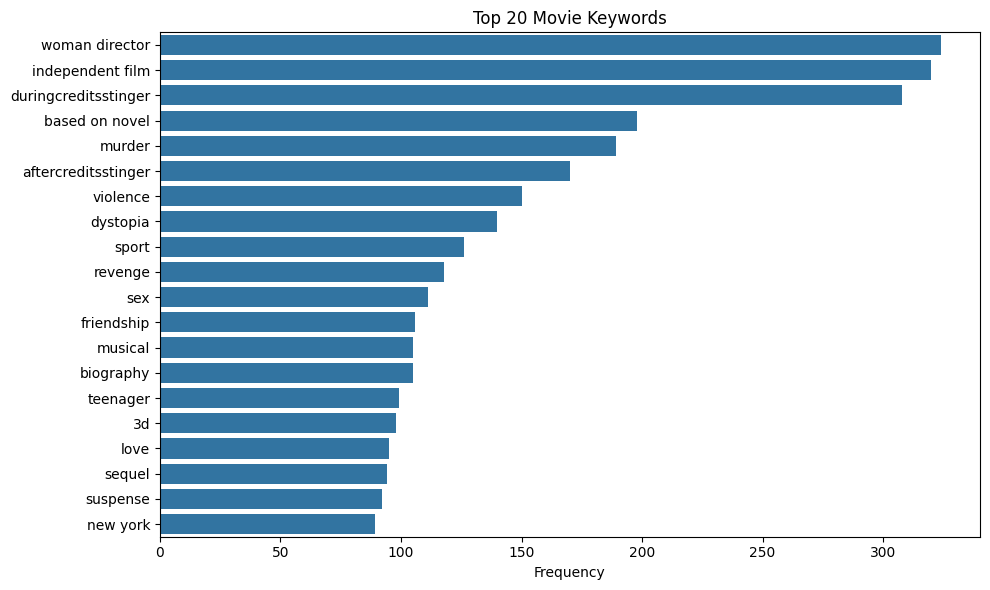

In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure keywords are list (skip eval if already parsed)
if isinstance(movies['keywords'].iloc[0], str):
    import ast
    movies['keywords'] = movies['keywords'].apply(ast.literal_eval)
    movies['keywords'] = movies['keywords'].apply(lambda x: [k['name'] for k in x])

# Flatten the keyword list
all_keywords = sum(movies['keywords'], [])
keyword_counts = Counter(all_keywords)
top_keywords = keyword_counts.most_common(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=[count for word, count in top_keywords], y=[word for word, count in top_keywords])
plt.title("Top 20 Movie Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.savefig("top_keywords.png")
plt.show()


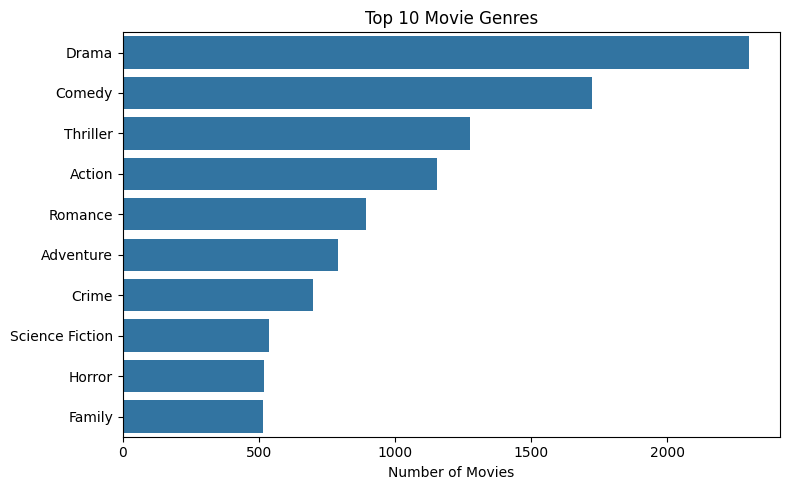

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure genres are list (skip eval if already parsed)
if isinstance(movies['genres'].iloc[0], str):
    import ast
    movies['genres'] = movies['genres'].apply(ast.literal_eval)
    movies['genres'] = movies['genres'].apply(lambda x: [g['name'] for g in x])

# Flatten genre list
all_genres = sum(movies['genres'], [])
genre_counts = Counter(all_genres)
top_genres = genre_counts.most_common(10)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=[count for g, count in top_genres], y=[g for g, count in top_genres])
plt.title("Top 10 Movie Genres")
plt.xlabel("Number of Movies")
plt.tight_layout()
plt.savefig("top_genres.png")
plt.show()


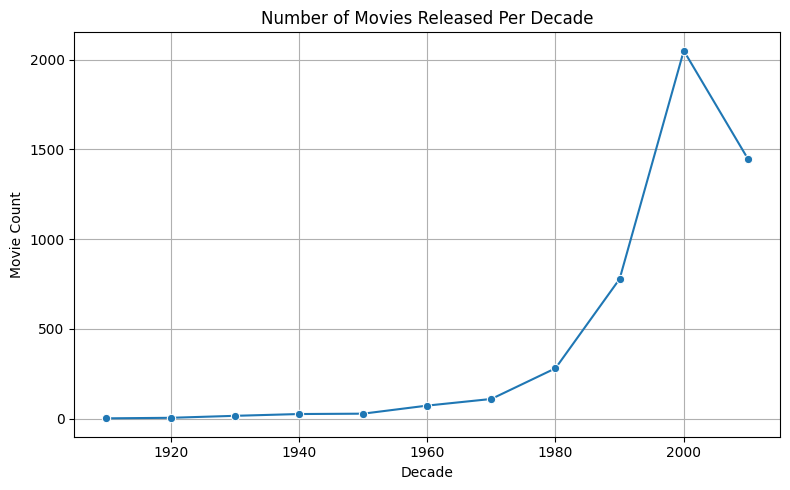

In [13]:
# Reload original CSV and merge again just for the date
import pandas as pd

movies_raw = pd.read_csv("tmdb_5000_movies.csv")
credits_raw = pd.read_csv("tmdb_5000_credits.csv")
movies_full = movies_raw.merge(credits_raw, on='title')

# Ensure release_date is parsed
movies_full['release_date'] = pd.to_datetime(movies_full['release_date'], errors='coerce')
movies_full['decade'] = (movies_full['release_date'].dt.year // 10) * 10

# Count and sort by decade
decade_counts = movies_full['decade'].value_counts().sort_index()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.lineplot(x=decade_counts.index, y=decade_counts.values, marker='o')
plt.title("Number of Movies Released Per Decade")
plt.xlabel("Decade")
plt.ylabel("Movie Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("movies_per_decade.png")
plt.show()



In [14]:
import pickle

# Save the movie data and similarity matrix
pickle.dump(final, open("movie_titles.pkl", "wb"))
pickle.dump(similarity, open("movie_similarity.pkl", "wb"))
